# SA-CCR Demo

## Imports and session creation


In [1]:
import atoti as tt
import datetime as dt
import datetime
from math import pi, sqrt
import numpy as np
from pandas.tseries.offsets import BDay
import pandas as pd

In [2]:
config = tt.config.create_config(metadata_db="./metadata.db")
session = tt.create_session(config = config)
session.url

'http://localhost:53962'

## Data Loading

In [3]:
number_of_days_in_year = 365.25
number_of_dates = 5
today =  dt.date(2020, 1, 13)
dates = []
for i in range(number_of_dates):
    dates.append((today + BDay(i)))

data_folder = "s3://data.atoti.io/notebooks/sa-ccr/"
data_folder_static = data_folder + "static/"
data_folder_generated = data_folder + "inverted/"
data_folder_simulations = data_folder + "simulations/"

In [4]:
#Creating the session and loading the data files into stores
def date_str(date):
    return str(date)[0:10]

store = session.read_csv(
    data_folder_generated + "trades_preprocessed/trades_preprocessed_2020-01-13.csv",
    keys = ["AsOfDate","TradeId"],
    types= {
        "Notional": tt.types.DOUBLE,
        "MarketValue": tt.types.DOUBLE,
        "AsOfDate": tt.types.LOCAL_DATE,
        "Mi": tt.types.LOCAL_DATE,
        "Si": tt.types.LOCAL_DATE,
        "Ti": tt.types.LOCAL_DATE,
        "Ei": tt.types.LOCAL_DATE
}
)

books_store = session.read_csv(
    data_folder_generated + "books/books_2020-01-13.csv", 
    keys = ["AsOfDate","BookId"]
)
counterparties_store = session.read_csv(
    data_folder_generated + "counterparties/counterparties_2020-01-13.csv", 
    keys = ["AsOfDate","CounterpartyId"]
) 
countries_store = session.read_csv(
    data_folder_generated + "countries.csv", keys = ["Country"]
)
desks_store = session.read_csv(
    data_folder_generated + "desks/desks_2020-01-13.csv", 
    keys = ["AsOfDate","DeskId"]
)
nettingSets_store = session.read_csv(
    data_folder_generated + "nettingSets/nettingSets_2020-01-13.csv", 
    keys = ["AsOfDate","NettingId"], 
    types = {"MPOR": tt.types.DOUBLE , "Collateral": tt.types.DOUBLE}
)
products_store = session.read_csv(
    data_folder_generated + "products/products_2020-01-13.csv",
    keys = ["ProductId"]
)
supervisoryParameters_store = session.read_csv(
    data_folder_static + "supervisoryParameters.csv",
    keys = ["AssetClass","Subclass"]
)

for i in range(14,18):
    store.load_csv(data_folder_generated + "trades_preprocessed/trades_preprocessed_2020-01-" 
                   + str(i) + ".csv")
    books_store.load_csv(data_folder_generated + "books/books_2020-01-"
                         + str(i) + ".csv")
    counterparties_store.load_csv(data_folder_generated + "counterparties/counterparties_2020-01-"
                                  + str(i) + ".csv")
    desks_store.load_csv(data_folder_generated + "desks/desks_2020-01-"
                         + str(i) + ".csv")
    nettingSets_store.load_csv(data_folder_generated + "nettingSets/nettingSets_2020-01-"
                               + str(i) + ".csv")
    products_store.load_csv(data_folder_generated + "products/products_2020-01-"
                            + str(i) + ".csv")


session.load_all_data()

In [5]:
store.head()

ProductId NettingSetId  BankEntityId BookId Direction  \
AsOfDate   TradeId                                                         
2020-01-13 t1          prod1          EX1             1  book1     Short   
           t2          prod2          EX1             1  book1      Long   
           t3          prod3          EX1             1  book1      Long   
           t4          prod4          EX1             1  book1     Short   
           t5          prod5          EX1             1  book1      Long   

                      Notional  MarketValue InputCurrency   Instrument  \
AsOfDate   TradeId                                                       
2020-01-13 t1       30000000.0       -400.0           GBP      forward   
           t2       46000000.0          0.0           GBP          CDS   
           t3           6700.0   39760000.0           GBP  Cash Equity   
           t4       36000000.0     -11000.0           GBP         swap   
           t5       10000000.0        150.0           GBP      forward   

                            AssetClass  ... Underlying Price  Attachment  \
AsOfDate   TradeId                      ...                                
2020-01-13 t1                Commodity  ...              NaN         NaN   
           t2             Credit Index  ...              NaN         NaN   
           t3       Equity Single Name  ...      5934.328358         NaN   
           t4            Interest Rate  ...              NaN         NaN   
           t5                Commodity  ...              NaN         NaN   

                   Detachment IndependentAmount    Fund  Mi_pd  \
AsOfDate   TradeId                                               
2020-01-13 t1             NaN               NaN  Fund_0   1461   
           t2             NaN               NaN  Fund_1   2922   
           t3             NaN               NaN  Fund_2  10958   
           t4             NaN               NaN  Fund_3   4749   
           t5             NaN               NaN  Fund_4   1461   

                   MaturityBuckets      RiskClass  Hedge_Set  SP_subclass  
AsOfDate   TradeId                                                         
2020-01-13 t1                    2      Commodity     Energy  Electricity  
           t2                    3         Credit     Credit           SG  
           t3                    3         Equity     Equity          N/A  
           t4                    3  Interest Rate        JPY          N/A  
           t5                    2      Commodity     Energy  Electricity  

[5 rows x 29 columns]

In [6]:
#Making the appropriate jointures

books_store.join(desks_store)
store.join(books_store, mapping = {"BookId": "BookId", "AsOfDate": "AsOfDate"})
store.join(products_store, mapping = {"ProductId": "ProductId", "AsOfDate": "AsOfDate"})
store.join(
    nettingSets_store, mapping = {"NettingSetId": "NettingId", "AsOfDate": "AsOfDate"}
)
store.join(
    supervisoryParameters_store, 
    mapping = {"AssetClass": "AssetClass", "SP_subclass": "Subclass"}
)
nettingSets_store.join(
    counterparties_store, 
    mapping = {"CounterpartyId": "CounterpartyId", "AsOfDate": "AsOfDate"}
)
counterparties_store.join(countries_store, mapping = {"CountryOfAddress": "Country"})

In [7]:
store.head()

ProductId NettingSetId  BankEntityId BookId Direction  \
AsOfDate   TradeId                                                         
2020-01-13 t1          prod1          EX1             1  book1     Short   
           t2          prod2          EX1             1  book1      Long   
           t3          prod3          EX1             1  book1      Long   
           t4          prod4          EX1             1  book1     Short   
           t5          prod5          EX1             1  book1      Long   

                      Notional  MarketValue InputCurrency   Instrument  \
AsOfDate   TradeId                                                       
2020-01-13 t1       30000000.0       -400.0           GBP      forward   
           t2       46000000.0          0.0           GBP          CDS   
           t3           6700.0   39760000.0           GBP  Cash Equity   
           t4       36000000.0     -11000.0           GBP         swap   
           t5       10000000.0        150.0           GBP      forward   

                            AssetClass  ... Underlying Price  Attachment  \
AsOfDate   TradeId                      ...                                
2020-01-13 t1                Commodity  ...              NaN         NaN   
           t2             Credit Index  ...              NaN         NaN   
           t3       Equity Single Name  ...      5934.328358         NaN   
           t4            Interest Rate  ...              NaN         NaN   
           t5                Commodity  ...              NaN         NaN   

                   Detachment IndependentAmount    Fund  Mi_pd  \
AsOfDate   TradeId                                               
2020-01-13 t1             NaN               NaN  Fund_0   1461   
           t2             NaN               NaN  Fund_1   2922   
           t3             NaN               NaN  Fund_2  10958   
           t4             NaN               NaN  Fund_3   4749   
           t5             NaN               NaN  Fund_4   1461   

                   MaturityBuckets      RiskClass  Hedge_Set  SP_subclass  
AsOfDate   TradeId                                                         
2020-01-13 t1                    2      Commodity     Energy  Electricity  
           t2                    3         Credit     Credit           SG  
           t3                    3         Equity     Equity          N/A  
           t4                    3  Interest Rate        JPY          N/A  
           t5                    2      Commodity     Energy  Electricity  

[5 rows x 29 columns]

## Cube creation, basic hierarchies and measures

In [8]:
cube = session.create_cube(store, "main_cube", mode = "no_measures")
cube.query()

,contributors.COUNT
0,2548


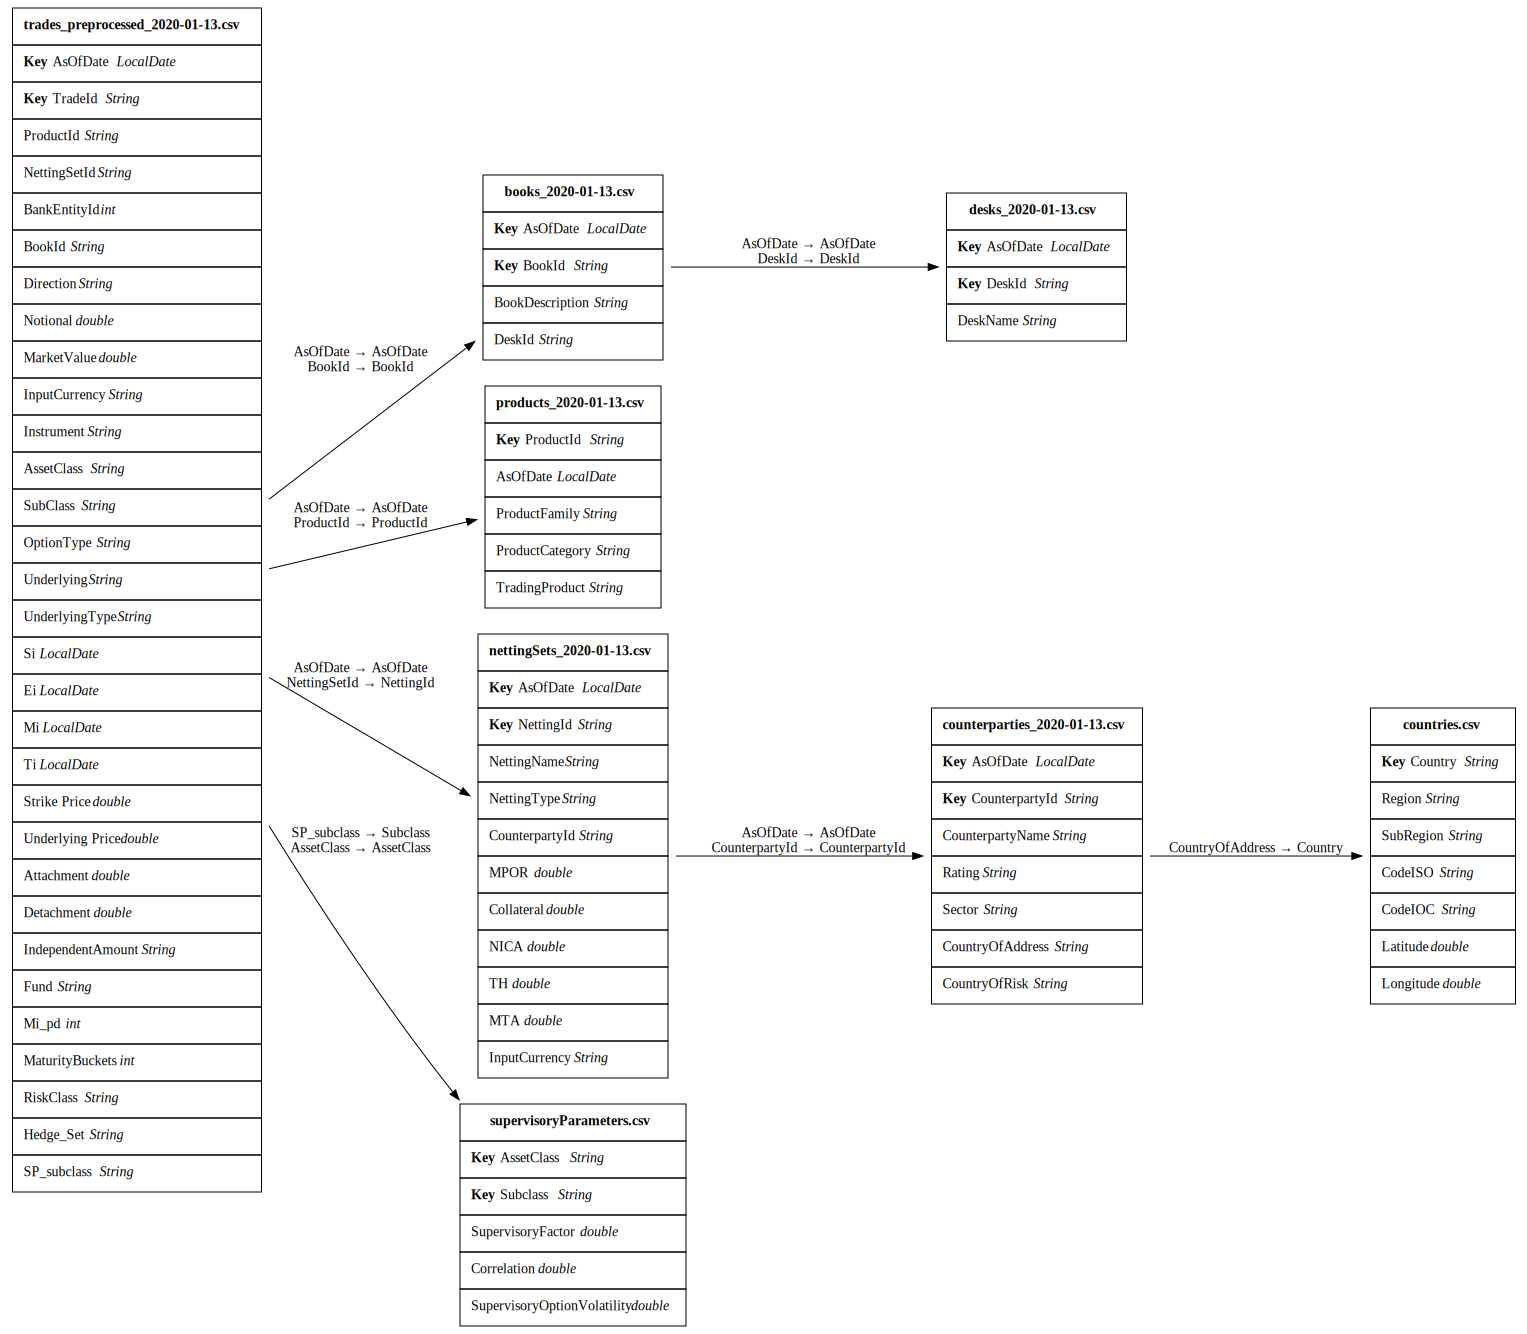

In [9]:
cube.schema

In [10]:
lvl = cube.levels
m = cube.measures
h = cube.hierarchies
h["AsOfDate"].slicing = True
lvl["AsOfDate"].comparator = tt.comparator.DESC

In [11]:
#Regrouping the hierarchies in the proper dimensions

h["AsOfDate"].dimension = "AsOfDate"

h["AssetClass"].dimension ="AssetClass"
h["SubClass"].dimension = "AssetClass"

h["CounterpartyName"].dimension = "Counterparties"
h["Rating"].dimension = "Counterparties"
h["Sector"].dimension = "Counterparties"

h["CountryOfRisk"].dimension = "Countries"
h["CountryOfAddress"].dimension = "Countries"

h["Direction"].dimension = "Direction"

h["Hedge_Set"].dimension = "Hedge_Set"

h["Instrument"].dimension = "Instrument"

h["MaturityBuckets"].dimension = "MaturityBuckets"

h["NettingName"].dimension = "NettingSets"
h["NettingType"].dimension = "NettingSets"
h["NettingSetId"].dimension = "NettingSets"

h["OptionType"].dimension = "OptionType"

h["ProductId"].dimension = "ProductId"

h["RiskClass"].dimension = "RiskClass"

h["TradeId"].dimension = "TradeId"

h["Ei"].dimension = "TradeAttributes"
h["Mi"].dimension = "TradeAttributes"
h["Si"].dimension = "TradeAttributes"
h["Ti"].dimension = "TradeAttributes"

h["InputCurrency"].dimension = "TradeInputCurrency"

h["Underlying"].dimension = "Underlyings"
h["UnderlyingType"].dimension = "Underlyings"



In [12]:
add_on_folder = "Add-On"
commodity_folder = "Commodity"
equity_folder = "Equity"
fx_folder = "FX"
credit_folder = "Credit"
ir_folder = "Interest Rate"
technical_folder = "Technical"
separator_folder = "\\"

trade_effective_folder = "Trade Effective"
detail_folder = "Detail"


#### Creating the measures needed

In [13]:
m["Notional"] = tt.agg.sum(store["Notional"])
m["MarketValue"] = tt.agg.sum(store["MarketValue"])
m["Attachment"] = tt.agg.single_value(store["Attachment"])
m["Detachment"] = tt.agg.single_value(store["Detachment"])
m["Underlying Price"] = tt.agg.single_value(store["Underlying Price"])
m["Strike Price"] = tt.agg.single_value(store["Strike Price"])
                
                
m["Collateral.VALUE"] = tt.agg.single_value(nettingSets_store["Collateral"])
m["MPOR.VALUE"] = tt.agg.single_value(nettingSets_store["MPOR"])
m["MTA.VALUE"] = tt.agg.single_value(nettingSets_store["MTA"])
m["NICA.VALUE"] = tt.agg.single_value(nettingSets_store["NICA"])
m["TH.VALUE"] = tt.agg.single_value(nettingSets_store["TH"])
                
m["SupervisoryFactor"] = tt.agg.single_value(
    supervisoryParameters_store["SupervisoryFactor"]
)
m["Correlation"] = tt.agg.single_value(supervisoryParameters_store["Correlation"])
m["Supervisory_Option_Volatility"] = tt.agg.single_value(
    supervisoryParameters_store["SupervisoryOptionVolatility"]
)


m["Supervisory_Option_Volatility"].folder = trade_effective_folder
m["SupervisoryFactor"].formatter = "DOUBLE[#,###.0000]"
m["SupervisoryFactor"].folder = technical_folder
m["Correlation"].folder = technical_folder


# SA-CCR calculations

The goal of this notebook is to determine the Exposure At Default (EAD) of a bank. The EAD is a risk indicator, that grows with the risk. It is aggregated from all the trades the bank is involved in, according to the folowing process:

- For each trade, the Notional is converted to the Trade Effective Notional
- The Trade Effective Notional is then aggregated across Risk Classes to form the $AddOn^{Agg}$, a main component of the EAD
- The EAD is determined using the $AddOn^{Agg}$

For the purpose of the demo, as the initial Basel data was too small (22 trades), we generated a similar dataset, with more than 500 trades following the same format, spread across 10 Netting Sets and the 5 Risk Classes. These trades are represented for everyday of a business week, with parameters such as the market value of the trades changing from one day to the others, and some new trades being issued. Furthermore, some useful hierarchies directly derived from the data but that weren't present in the dataset were added to the files during their generation to speed up calculations. All the following pivot tables and graphs use these generated trades. 

## Trade Effective Notional Calculations

The first thing to determine in order to compute the EAD is the Trade Effective Notional. Derived from the Notional of the trades, it is the main component of the Add-Ons that are aggregated to make the EAD

In order to determine the Trade Effective Notional, we first need to compute the Adjusted notional.

$$AdjustedNotional = Notional * SupervisoryDuration$$

$$SupervisoryDuration = \frac{(exp(-0.05*S_i) - exp(-0.05*E_i))}{0.05}$$ for Credits and Interest Rates and 1 for other Asset Classes. 

In this expression, $S_i$ is the start date of trade $i$ and $E_i$ the end date of trade $i$  (see saccr paragraph 157)

In [14]:
m["s_i_diff"] = tt.filter(
    tt.date_diff(lvl["AsOfDate"], lvl["Si"], unit = "days")/number_of_days_in_year,
    lvl["RiskClass"].isin("Interest Rate", "Credit")
)
m["e_i_diff"] = tt.filter(
    tt.date_diff(lvl["AsOfDate"], lvl["Ei"], unit = "days")/number_of_days_in_year, 
    lvl["RiskClass"].isin("Interest Rate", "Credit")
)
 
    
m["s_i_diff"].folder = trade_effective_folder + separator_folder + detail_folder
m["e_i_diff"].folder = trade_effective_folder + separator_folder + detail_folder

m["Supervisory_Duration"] = tt.where(
    lvl["RiskClass"].isin("Interest Rate", "Credit"),
    (tt.exp(-0.05*m["s_i_diff"])-tt.exp(-0.05*m["e_i_diff"]))/0.05,
    1.0
)
m["Supervisory_Duration"].folder = trade_effective_folder

In [16]:
# cube.pivot(measures=[s_i_diff, e_i_diff, SDIR, SDCI, SDCSN, Supervisory_Duration], rows=["AssetClass", "Si", "Ei"], columns="AsOfDate")
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

Adding Adjusted Notional

In [16]:
m["Adjusted_Notional"] = tt.agg.sum(
    m["Notional"]*m["Supervisory_Duration"], scope = tt.scope.origin(lvl["AssetClass"])
)
m["Adjusted_Notional"].folder = trade_effective_folder

Now we can determine the Trade Effective Notional : 

$$TradeEffectiveNotional = AdjustedNotional * MaturityFactor * SupervisoryDelta$$

The Maturity Factor takes different values, depending on wether the trade is margined or unmargined (paragraph 164):

margined :

$$MF = 1.5 * \sqrt{\frac{MPOR}{1 year}}$$

unmargined :

$$MF = \sqrt{\frac{min(M_i, 1year)}{1year}}$$

The $MPOR$ is the Margin Period Of Risk, given in the dataset. $M_i$ is the maturity of trade $i$

In [17]:
m["m_i_diff"] = tt.date_diff(lvl["AsOfDate"], lvl["Mi"], unit = "days")
m["m_i_diff"].folder = trade_effective_folder + separator_folder + detail_folder

m["Maturity_Factor"] = tt.where(
    lvl["NettingType"] == "margined",
    1.5 * tt.sqrt(m["MPOR.VALUE"]/number_of_days_in_year), 
    tt.sqrt(min(m["m_i_diff"], number_of_days_in_year)/number_of_days_in_year)
)
m["Maturity_Factor"].folder = trade_effective_folder


Supervisory Delta takes different values depending on the nature of the instrument (paragraph 159) : 

| $\delta_i$        | Bought / Long in the primary risk factor                                          | Sold / Short in the primary risk factor                                            |
|-------------------|-----------------------------------------------------------------------------------|----------------------------------------------------------------------------------  |
| Call Options      | $+ \Phi(\frac{ln(P_i / K_i) + 0.5 * \sigma_i^2 * T_i}{\sigma_i * \sqrt{T_i}})$    | $ - \Phi(\frac{ln(P_i / K_i) + 0.5 * \sigma_i^2 * T_i}{\sigma_i * \sqrt{T_i}})$    |
| Put Options       | $- \Phi( - \frac{ln(P_i / K_i) + 0.5 * \sigma_i^2 * T_i}{\sigma_i * \sqrt{T_i}})$ | $ + \Phi( - \frac{ln(P_i / K_i) + 0.5 * \sigma_i^2 * T_i}{\sigma_i * \sqrt{T_i}})$ |
| CDO tranches      | $+ \frac{15}{(1+14*A_i)*(1+14*D_i)}$                                              | $- \frac{15}{(1+14*A_i)*(1+14*D_i)}$                                               |
| Other Instruments | $+1$                                                                              | $-1$                                                                               |

Where $\Phi$ is the Normal distribution function,

$P_i$ is the Underlying Price of trade $i$,

$K_i$ is the Strike Price of trade $i$,

$\sigma_i$ is the Supervisory Volatility of trade $i$,

$T_i$ is the latest contractual exercise date of the option $i$

$A_i$ is the Attachment value of the CDO tranche $i$

and $D_i$ is the Detachment value of the CDO tranche $i$

In [18]:
m["one"] = 1.0
m["one"].visible = False

m["t_i_diff"] = (
    tt.date_diff(lvl["AsOfDate"], lvl["Ti"], unit = "days") / number_of_days_in_year
)
m["t_i_diff"].folder = trade_effective_folder + separator_folder + detail_folder

S_delta_else_long = tt.filter(
    m["one"],
    (lvl["Direction"] == "Long") 
    & (lvl["Instrument"] != "option") 
    & (lvl["Instrument"] != "CDO")
)
S_delta_else_short = tt.filter(
    (-1.0)*m["one"], 
    (lvl["Direction"] == "Short") 
    & (lvl["Instrument"] != "option") 
    & (lvl["Instrument"] != "CDO")
)

def dl_erf(x):
    """ Taylor expansion of the error function at order 9 """
    return (2/sqrt(pi)) * (
        x  - (1.0/3.0) * (x**3) + (1.0/10.0) * (x**5) - (1.0/42.0) * (x**7) 
    )
    

def phi(x): 
    """ Normal distribution function """
    return (1.0 + dl_erf(x/sqrt(2))) / 2.0

put = tt.where(lvl["OptionType"] == "P", -1.0, 1.0)


bought = tt.where(m["MarketValue"]>0, 1.0, -1.0)

m["lnPK"] = tt.log(m["Underlying Price"]/m["Strike Price"])
m["lnPK"].folder = trade_effective_folder + separator_folder + detail_folder
m["sigma_sqrtTi"] = m["Supervisory_Option_Volatility"] * tt.sqrt(m["t_i_diff"])
m["sigma_sqrtTi"].folder = trade_effective_folder + separator_folder + detail_folder
m["argument_phi"] = (m["lnPK"]  +  0.5 * (m["sigma_sqrtTi"]**2)) / m["sigma_sqrtTi"]
m["argument_phi"].folder = trade_effective_folder + separator_folder + detail_folder

S_delta_option = tt.filter(
    bought * put * phi( put * m["argument_phi"])  , lvl["Instrument"] == "option"
)

S_delta_CDO = tt.filter(
    bought * 15.0 / ((1.0 + 14.0 * m["Attachment"]) * (1.0 + 14.0 * m["Detachment"])),
    lvl["Instrument"] == "CDO",
)

m["S_delta"] = S_delta_option + S_delta_else_long + S_delta_else_short + S_delta_CDO
m["S_delta"].folder = trade_effective_folder + separator_folder + detail_folder

Adding Trade Effective Notional

In [19]:
m["Trade_Effective_Notional"] = tt.agg.sum(
    m["Adjusted_Notional"] * m["S_delta"] * m["Maturity_Factor"], 
    scope = tt.scope.origin(lvl["TradeId"]),
)

In [21]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

## Add-on Calculations

Each trade has a RiskClass (or AssetClass) which corresponds to its primary risk factor. There are 5 Risk Classes : Interest Rate (IR), Credit (CR), Commodity (CO), Foreign Exchange (FX) and Equity (EQ). The Add-On aggregate used in the EAD calculations is the sum of the 5 add-ons determined for each one of these Risk Classes. Each Class is divided in Hedge Sets. The Add-On is aggregated from the Trade Effective Notional in each Hedge Set, following different formulas depending on the Risk Class. The Add-On of a Risk Class is the sum of the Add-Ons of its Hedge Sets. (part I/B) 

### 1: Interest Rates (IR) add on

Interest rates are separated in one hedge set for each currency used.
Each hedge set is then separated in maturity buckets depending on $M_i$. If $M_i$ is less than one year, the trade goes in the first Maturity Bucket, if it is between one and five years, the trade goes in the second Maturity Bucket, and if it is more than 5 years the trade goes in the third Maturity Bucket.


In each Maturity Bucket $k$ of Hedge Set $j$, the effective notional $EN_{j,k}$ is the sum of the Trade Effective Notionals of the trades. 
The effective notional $EN_j$ of the Hedge Set $j$ is then determined with the following formula :

$$EN_{j} = ( EN_{j,1}^2 + EN_{j,2}^2 + EN_{j,3}^2 + 1.4 * EN_{j,1} * EN_{j,2} + 1.4 * EN_{j,2} * EN_{j,3} + 0.6 * EN_{j,1} * EN_{j,3} )^{\frac{1}{2}}$$

The Add-On for each hedge set is then simply : 

$$AddOn_{j}^{(IR)} = SF^{(IR)} * EN_j $$

where $SF^{IR}$ is the Supervisory Factor for Interest Rate assets (given in the supervisory parameters store)

The Add_On for Interest Rate assets is then the sum of the $AddOn_{j}^{(IR)}$ on the hedge sets.


In [22]:
m["Effective_notional_IR_j_k"] = tt.filter(
    m["Trade_Effective_Notional"], lvl["AssetClass"] == "Interest Rate"
)
m["Effective_notional_IR_j_k"].folder = (
    add_on_folder + separator_folder + ir_folder + separator_folder + detail_folder
)
m["Effective_notional_IR_j_k"].formatter = "DOUBLE[#,###]"


In [23]:
m["carres_Djk"] = tt.agg.sum(
    (m["Effective_notional_IR_j_k"]**2), 
    scope = tt.scope.origin(lvl["Hedge_Set"],lvl["MaturityBuckets"]),
) 
m["carres_Djk"].folder = (
    add_on_folder + separator_folder + ir_folder + separator_folder + detail_folder
)

In [24]:
effective_notional_per_hedge_set = tt.agg.sum(
    m["Effective_notional_IR_j_k"], scope = tt.scope.origin(lvl["Hedge_Set"])
)

effective_notional_per_hedge_set_mb1 = tt.filter(
    effective_notional_per_hedge_set, lvl["MaturityBuckets"] == 1
)
effective_notional_per_hedge_set_mb2 = tt.filter(
    effective_notional_per_hedge_set, lvl["MaturityBuckets"] == 2
)
effective_notional_per_hedge_set_mb3 = tt.filter(
    effective_notional_per_hedge_set, lvl["MaturityBuckets"] == 3
)

m["Effective_notional_IR_j"] = tt.sqrt(
    m["carres_Djk"] 
    + 1.4 * effective_notional_per_hedge_set_mb1 * effective_notional_per_hedge_set_mb2 
    + 1.4 * effective_notional_per_hedge_set_mb2 * effective_notional_per_hedge_set_mb3 
    + 0.6 * effective_notional_per_hedge_set_mb1 * effective_notional_per_hedge_set_mb3
)
m["Effective_notional_IR_j"].folder = (
    add_on_folder + separator_folder + ir_folder + separator_folder + detail_folder
)
m["Effective_notional_IR_j"].formatter = "DOUBLE[#,###]"


In [25]:
m["AddOn_IR_j"] = m["SupervisoryFactor"] * m["Effective_notional_IR_j"]
m["AddOn_IR_j"].folder = (
    add_on_folder + separator_folder + ir_folder + separator_folder + detail_folder
)
m["AddOn_IR_j"].formatter = "DOUBLE[#,###]"
m["AddOn_IR"] =tt.agg.sum(m["AddOn_IR_j"], scope = tt.scope.origin(lvl["Hedge_Set"]))
m["AddOn_IR"].folder = add_on_folder + separator_folder + ir_folder
m["AddOn_IR"].formatter = "DOUBLE[#,###]"

In [27]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

### 2: Credit (CR) add on

There is only one Hedge Set for Credit derivatives. In this Hedge Set, the trades are grouped depending on which entity issued them. The Add-On for an entity is the sum of the Trade Effective Notionals of the corresponding trades, multiplied by the Supervisory Factor. The Supervisory Factor depends on the rating of the entity. 


In [28]:
m["AddOn_CR_per_entity"] = tt.filter(
    m["SupervisoryFactor"] * m["Trade_Effective_Notional"], lvl["RiskClass"] == "Credit"
)
m["AddOn_CR_per_entity"].folder = add_on_folder + separator_folder + credit_folder
m["AddOn_CR_per_entity"].formatter = "DOUBLE[#,###]"


After determining the AddOn per entity, we can deduce the Credit AddOn with the following formula (paragraph 173) :

$$ AddOn^{(CR)} = [(\sum_{k} \rho_{k}^{(CR)} *  AddOn(Entity_{k}) )^{2} + \sum_{k} (1-(\rho_{k}^{(CR)} )^{2}) *  (AddOn(Entity_{k}))^{2} ]^{1/2}$$

where $\rho_k^{(CR)}$ is the Correlation. It takes different values wether the trade's Asset Class is Credit Single Name or Credit Index (the two possible Asset Class for Credit derivatives).

In [29]:
squared_sum_CR = (
    tt.agg.sum(
        m["Correlation"] * m["AddOn_CR_per_entity"],
        scope = tt.scope.origin(lvl["Underlying"])
    )
    ** 2
)

sum_of_squares_CR = tt.agg.sum( 
    (1.0 - (m["Correlation"]**2)) * (m["AddOn_CR_per_entity"]**2),
    scope = tt.scope.origin(lvl["Underlying"]),
)

m["AddOn_CR"] = tt.sqrt(squared_sum_CR + sum_of_squares_CR)
m["AddOn_CR"].folder = add_on_folder + separator_folder + credit_folder
m["AddOn_CR"].formatter = "DOUBLE[#,###]"


In [31]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

### 3: Commodity (CO) Add-On

Commodities are separated in 4 Hedge Sets : Energy, Metals, Agricultural and Others depending on the commodity exchanged.
Inside these Hedge Sets, the trades are grouped following the underlying type of commodity exchanged. For example, inside the Energy Hedge Set, trades may belong to the "Oil/Gas" bucket, or to the "Electricity" bucket.
The Add-On for one of these bucket is simply the sum of the Trade Effective Notionals, multiplied by the Supervisory Factor (different for each Hedge Set).

Within each hedging set $j$, the add-on is calculated following the formula in paragraph 179 :

$$ AddOn_{HS_{j}}^{(CO)} = [(\rho_{j}^{(CO)} * \sum_{k}  AddOn(Type_{k}^{ j}) )^{2} + (1-(\rho_{j}^{(CO)} )^{2}) * \sum_{k}  (AddOn(Type_{k}^{ j}))^{2} ]^{1/2}$$

Where $\rho_j^{(CO)}$ is the Correlation and $Type_k^j$ the $k$-th type bucket of Hedge Set $j$.

The global commodity Add-On is then the sum of the 4 Hedge Set Add-Ons

In [32]:
m["AddOn_CO_j_k"] = tt.filter(
    m["SupervisoryFactor"] * m["Trade_Effective_Notional"], 
    lvl["AssetClass"] == "Commodity",
)
m["AddOn_CO_j_k"].folder = add_on_folder + separator_folder + commodity_folder
m["AddOn_CO_j_k"].formatter = "DOUBLE[#,###]"


In [33]:
squared_sum_CO = (
    tt.agg.sum(
        m["Correlation"] * m["AddOn_CO_j_k"],
        scope = tt.scope.origin(lvl["Underlying"],lvl["UnderlyingType"])
    )
    ** 2
)
sum_of_squares_CO = tt.agg.sum(
    (1.0 - (m["Correlation"]**2)) * (m["AddOn_CO_j_k"]**2), 
    scope = tt.scope.origin(lvl["Underlying"],lvl["UnderlyingType"]),
)
m["AddOn_CO_j"] = tt.sqrt(squared_sum_CO + sum_of_squares_CO)
m["AddOn_CO_j"].folder = add_on_folder + separator_folder + commodity_folder
m["AddOn_CO_j"].formatter = "DOUBLE[#,###]"


m["AddOn_CO"] = tt.agg.sum(m["AddOn_CO_j"], scope = tt.scope.origin(lvl["Hedge_Set"]))
m["AddOn_CO"].folder = add_on_folder + separator_folder + commodity_folder
m["AddOn_CO"].formatter = "DOUBLE[#,###]"

In [35]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

### 4: Foreign Exchange (FX) Add-On

Foreign Exchange trades are separated in one Hedge Set for each currency pair (paragraph 170). 
Inside of each Hedge Sets, the add-on is determined by multiplying the absolute value of the sum of Trade Effective Notionals by the corresponding Supervisory Factor :

$$AddOn_{HS_{j}}^{(FX)} = SF_{j}^{(FX)} * |EffectiveNotional_{j}^{(FX)}| $$

and :

$$AddOn^{(FX)} = \sum_{j} AddOn_{HS_{j}}^{(FX)} $$


In [36]:
m["AddOn_FX_j"] = tt.filter(
    m["SupervisoryFactor"] * tt.abs(m["Trade_Effective_Notional"]),
    lvl["AssetClass"] == "FX",
)
m["AddOn_FX_j"].folder = add_on_folder + separator_folder + fx_folder
m["AddOn_FX_j"].formatter = "DOUBLE[#,###]"


m["AddOn_FX"] = tt.agg.sum(m["AddOn_FX_j"], scope = tt.scope.origin(lvl["Hedge_Set"]))
m["AddOn_FX"].folder = add_on_folder + separator_folder + fx_folder
m["AddOn_FX"].formatter = "DOUBLE[#,###]"


In [38]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

### 5: Equity (EQ) derivatives Add-On

Equity Add-On is determined in the same way as Credit Add-On. The trades are grouped under a single Hedge Set, and grouped by entity inside. However, the supervisory factor no longer depends on the rating of the entity but rather on wether the trade's Asset Class is Equity Index or Equity Single Name. The formula to determine its value from the Trade Effective Notional is in paragraph 177 :

$$ AddOn^{(EQ)} = [(\sum_{k} \rho_{k}^{(EQ)} *  AddOn(Entity_{k}) )^{2} + \sum_{k} (1-(\rho_{k}^{(EQ)} )^{2}) *  (AddOn(Entity_{k}))^{2} ]^{1/2}$$

where $\rho_{k}$ is the correlation factor corresponding to entity k


In [39]:
m["AddOn_EQ_per_entity"] = tt.filter(
    m["SupervisoryFactor"] * m["Trade_Effective_Notional"], lvl["RiskClass"] == "Equity"
)
m["AddOn_EQ_per_entity"].folder = add_on_folder + separator_folder + equity_folder
m["AddOn_EQ_per_entity"].formatter = "DOUBLE[#,###]"


In [40]:
squared_sum_EQ = (
    tt.agg.sum(
        m["Correlation"] * m["AddOn_EQ_per_entity"],
        scope = tt.scope.origin(lvl["Underlying"])
    )
    ** 2
)

sum_of_squares_EQ = tt.agg.sum( 
    (1.0 - (m["Correlation"]**2)) * (m["AddOn_EQ_per_entity"] ** 2), 
    scope = tt.scope.origin(lvl["Underlying"]),
)

m["AddOn_EQ"] = tt.sqrt(squared_sum_EQ + sum_of_squares_EQ)
m["AddOn_EQ"].folder = add_on_folder + separator_folder + equity_folder
m["AddOn_EQ"].formatter = "DOUBLE[#,###]"


In [42]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

## Final Calculations
Now that we have determined the add-on corresponding to every risk class, we can determine the aggregated add-on, as their sum, and then calculate the EAD.

The Add-on aggregate is simply the sum of all five Risk Class Add-Ons

In [43]:
m["AddOn"] = (
    m["AddOn_CR"] + m["AddOn_IR"] + m["AddOn_CO"] + m["AddOn_FX"] + m["AddOn_EQ"]
)
m["AddOn"].folder = add_on_folder
m["AddOn"].formatter = "DOUBLE[#,###]"

m["AddOn D2D %"] = (
    m["AddOn"] - tt.shift(m["AddOn"], on=lvl["AsOfDate"], offset = 1)
) / m["AddOn"]

m["AddOn D2D %"].folder = add_on_folder
m["AddOn D2D %"].formatter = "DOUBLE[#,###.00%]"

$$EAD = \alpha * (RC + PFE)$$

where $alpha = 1.4$ (fixed parameter), 

the Replacement Cost  $RC = max(V-C,0)$ 

($V$ is the value of derivative transactions and $C$ is the haircut value of
net collateral held)


and the Potential Future Exposure $PFE = multiplier * AddOn^{aggregate}$

with 

$$multiplier = min(1, Floor + (1-Floor)*exp(\frac{V-C}{2*(1-Floor)*AddOn^{aggregate}})$$ 

(where $Floor = 0.05$ is another fixed parameter)

In [44]:
floor = 0.05
alpha = 1.4
m["Multiplier"] = tt.min(
    1.0, 
    floor 
    + (1 - floor)
    * tt.exp(
        (m["MarketValue"] - m["Collateral.VALUE"])/(2 * (1 - floor) * m["AddOn"])
    ),
)
m["Multiplier"].formatter = "DOUBLE[#,###]"

m["PFE"] = m["Multiplier"] * m["AddOn"]
m["PFE"].formatter = "DOUBLE[#,###]"

m["RC"] = tt.max(m["MarketValue"] - m["Collateral.VALUE"],0)
m["RC"].formatter = "DOUBLE[#,###]"

m["EAD"] = tt.agg.sum(
    alpha * (m["RC"] + m["PFE"]), scope = tt.scope.origin(lvl["NettingSetId"])
)
m["EAD"].formatter = "DOUBLE[#,###]"


In [46]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

Here, we have a recap of the final values for the AddOn, multiplier, PFE, RC and EAD for each of the 10 Netting Sets of our example.

In [48]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

This graph shows the evolution of the EAD for each Netting Set over the course of the business week represented in the dataset.

In [50]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

This graph shows the evolution of the AddOn for each RiskClass over the course of the business week represented in the dataset.

In [52]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

Here, we can observe the variations in EAD and Add-On over the course of the business week. A simple use case for a business user would be to identify the source of a variation observed in these graphs. For instance, in the last 24h, we can see the Commodity Add-On going up byabout 8% (from 101M to 110M). This corresponds to huge increase in risk, that may be an issue. Therefore, knowing the reason behind this change is important. In the following tables, we will try to identify which trade or trades are at the origin of this observation. 

In [54]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

In [56]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

After going down the pivot tables, we find out the change in CO add-on was due to the apparition of a new gold trade between the 16/01 and the 17/01. This new addition to the notional was at the root of the sudden shift in global add-on.

# Simulations : changing the rate of a firm

It is also possible to make simulations, to see the impact a sudden change of one of the usually constant variables would have on the add-on and the EAD.
The simulations presented here consist in changing the rating of one of the firms issuing the trades. 
In a first simulation, we downgrade Firm 4 's rating from AA to A. In a second one, we push the change a bit further by downgrading it to BBB.
In the calculations, the firm rating only impacted the supervisory factor for CR derivatives, so we only expect the $AddOn^{(CR)}$ to be impacted.
Since the AddOn and the EAD are measures of risk that grow when the risk increases, we expect these two indicators to grow between each simulation.

In [57]:
store.source_simulation_enabled = True

In [58]:
store.scenarios["Firm4 AA to BBB"].load_csv(data_folder_simulations
                                            + "firm4_AA_to_BBB.csv")
store.scenarios["Firm4 AA to A"].load_csv(data_folder_simulations 
                                          + "firm4_AA_to_A.csv")

session.load_all_data

<bound method Session.load_all_data of <atoti.session.Session object at 0x000002E4F0494A60>>

In [60]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

When we look at the Add-On for these trades (CSN + firm 10), we see that it has effectively increased, from 2.9M to 3.2M to 4.1M for firm 4, just as expected.

In [62]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

On observe bien également une montée de l'EAD global.